# Fast Moving Object (FMO) detection

Based on [Rozumnyi Kotera Sroubek Novotny Matas, CVPR 2017, "The World of Fast Moving Objects"](https://arxiv.org/pdf/1611.07889.pdf).

Initial implementation of the `detector` algorithm.

In [1]:
import cv2
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import time

%matplotlib inline


# WARNING: This will only work if Jupyter is run from the `notebooks` directory.
BASE = os.path.join('data', 'tennis')
VIDEO = os.path.join(BASE, 'Tennis-Sep2016.mov')
IMG_TEMPLATE = os.path.join(BASE, 'tennis-frame-{}.png')

## Extract sequence of frames from video

While the video plays, hit any key to move forward, frame-by-frame, use `s` to save the frame and `q` to stop.
The first three frames saved will be used in the subsequent detection phase

In [2]:
def extract_img(video, img_name):
    cap = cv2.VideoCapture(video)

    idx = 1
    while cap.isOpened():
        ret, frame = cap.read()
        cv2.imshow('tennis', frame)
        key = cv2.waitKey(0) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            img = img_name.format(idx)
            cv2.imwrite(img, frame)
            idx += 1

    cap.release()
    cv2.destroyAllWindows()

In [3]:
# Uncomment to extract fresh images to process.
#extract_img(VIDEO, IMG_TEMPLATE)

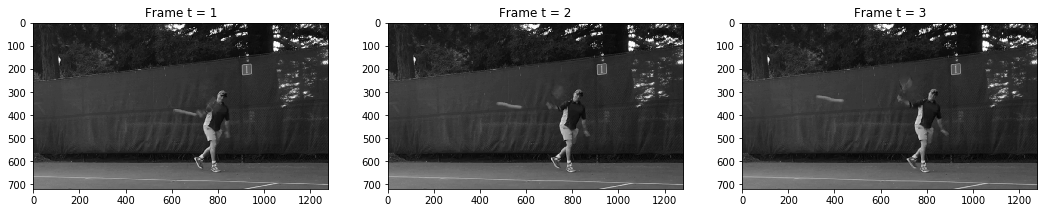

In [4]:
# We read the images as grayscale so they are ready for thresholding functions.
images = [cv2.imread(IMG_TEMPLATE.format(idx), cv2.IMREAD_GRAYSCALE) 
          for idx in range(1, 6)]
fig = plt.figure(figsize=(18, 16), edgecolor='k')

for t in range(1, 4):
    plt.subplot(1, 3, t)
    plt.imshow(images[t], 'gray')
    plt.title("Frame t = {}".format(t))
    im_tm1 = images[t - 1]
    im_t = images[t]
    im_tp1 = images[t + 1]

    delta_plus = cv2.absdiff(im_t, im_tm1)
    delta_0 = cv2.absdiff(im_tp1, im_tm1)
    delta_minus = cv2.absdiff(im_t,im_tp1)



## Thresholding

The "naive" approach would be to scan the differential image pixel by pixel, compute the norm and set it to a `1` value if it exceeds a certain threshold: this is very inefficient and time consuming.

A better approach is to use thresholding directly [implemented in OpenCV](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#thresholding).

In [5]:
def threshold(img, threshold, invert=False):
    """ Naively computes a binary image, given a threshold."""
    rows, columns = img.shape
    res = np.zeros((rows, columns), dtype = "uint8")

    for row in range(rows):
        for col in range(columns):
            xp = img[row, col]
            if xp > threshold:
                res[row, col] = 255 if not invert else 0
            else:
                res[row, col] = 0 if not invert else 255
    return res

In [6]:
def combine (dbp, dbm, db0r):
    """Combines the three binary images.
    
    If the corresponding pixel in all three images is non-zero, a "black" value is emitted
    in the result image, otherwise a "white" value.
    
    The resultant image should be a "negative" image of moving objects in the original frames.
    """
    rows, columns = dbp.shape
    res = np.zeros((rows, columns), dtype = "uint8")

    for row in range(rows):
        for col in range(columns):
            res[row, col] = 0 if dbp[row, col] > 0 and \
                dbm[row, col] > 0 and \
                db0r[row, col] > 0 else 255
    return res

## Implementation of the Detector algorithm

See section `4.1` of the reference, we essentially compute:

    Delta = Delta+ & Delta- & ~Delta0
    
 to isolate "candidate FMOs" (connected components of non-zero pixels).
 

In [7]:
sp = cv2.meanStdDev(delta_plus)
sm = cv2.meanStdDev(delta_minus)
s0 = cv2.meanStdDev(delta_0)
print("E(d+):", sp, "\nE(d-):", sm, "\nE(d0):", s0)


th = [
    sp[0][0, 0] + 3 * math.sqrt(sp[1][0, 0]),
    sm[0][0, 0] + 3 * math.sqrt(sm[1][0, 0]),
    s0[0][0, 0] + 3 * math.sqrt(s0[1][0, 0]),
]

print("Thresholds:", th)

start = time.time()
dbp = threshold(delta_plus, th[0])
dbm = threshold(delta_minus, th[1])
db0 = threshold(delta_0, th[2], invert=True)

detect_naive = combine(dbp, dbm, db0)
naive_time = (time.time() - start) * 1000

E(d+): (array([[ 2.09564996]]), array([[ 7.7852084]])) 
E(d-): (array([[ 2.26830404]]), array([[ 7.99989459]])) 
E(d0): (array([[ 2.89412543]]), array([[ 10.29426931]]))
Thresholds: [10.466245848016166, 10.75352951031255, 12.51953055866786]


## Using OpenCV Native Threshold function

### Native [Threshold functions](https://docs.opencv.org/3.0-last-rst/modules/imgproc/doc/miscellaneous_transformations.html#threshold)

In [8]:
start = time.time()
ret, dbp = cv2.threshold(delta_plus, th[0], 255, cv2.THRESH_BINARY)
ret, dbm = cv2.threshold(delta_minus, th[1], 255, cv2.THRESH_BINARY)
ret, db0 = cv2.threshold(delta_0, th[2], 255, cv2.THRESH_BINARY)

detect = cv2.bitwise_not(
    cv2.bitwise_and(cv2.bitwise_and(dbp, dbm), 
                    cv2.bitwise_not(db0)))

ocv_time = (time.time() - start) * 1000

### Adaptive threshold



Although, generally, an adaptive threshold would yield better results, in this applications it is significantly worse and should be avoided.

Not to mention, it's also significantly slower.

In [9]:
start = time.time()
dbp = cv2.adaptiveThreshold(delta_plus, 255, 
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
dbm = cv2.adaptiveThreshold(delta_minus, 255, 
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
db0 = cv2.adaptiveThreshold(delta_0, 255, 
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
tmp = cv2.bitwise_and(dbp, dbm)
detect_adaptive = cv2.bitwise_and(tmp, cv2.bitwise_not(db0))

adaptive_time = (time.time() - start) * 1000

### Spot the difference

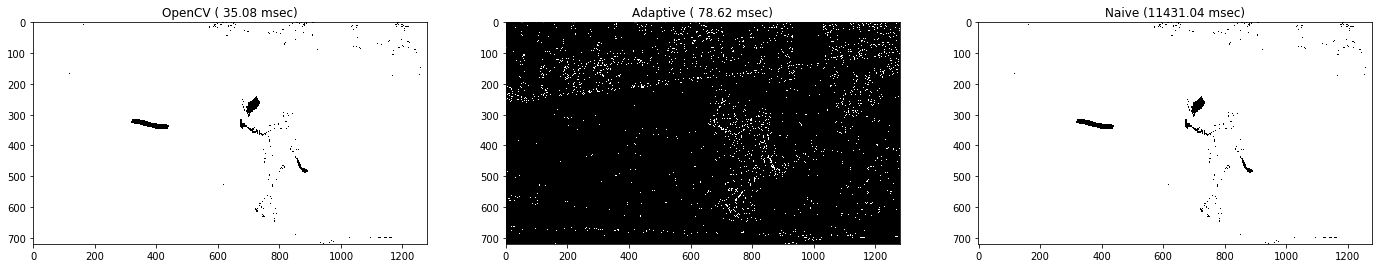

In [10]:
fig = plt.figure(figsize=(24, 20), edgecolor='k')

titles = ["OpenCV ({:6.2f} msec)".format(ocv_time),
          "Adaptive ({:6.2f} msec)".format(adaptive_time),
          "Naive ({:6.2f} msec)".format(naive_time),]
for t, img in enumerate([detect, detect_adaptive, detect_naive]):
    plt.subplot(1, 3, t + 1)
    plt.imshow(img, 'gray')
    plt.title(titles[t])
    cv2.imwrite(IMG_TEMPLATE.format(titles[t].split()[0]), img)


# Connected components

Using OpenCV [connectedComponentsWithStats](https://docs.opencv.org/3.0-last-rst/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#connectedcomponents) method, we extract from the image a set of components and, from those, we eliminate the ones whose area is too small to be a viable FOM.

Found 450 components


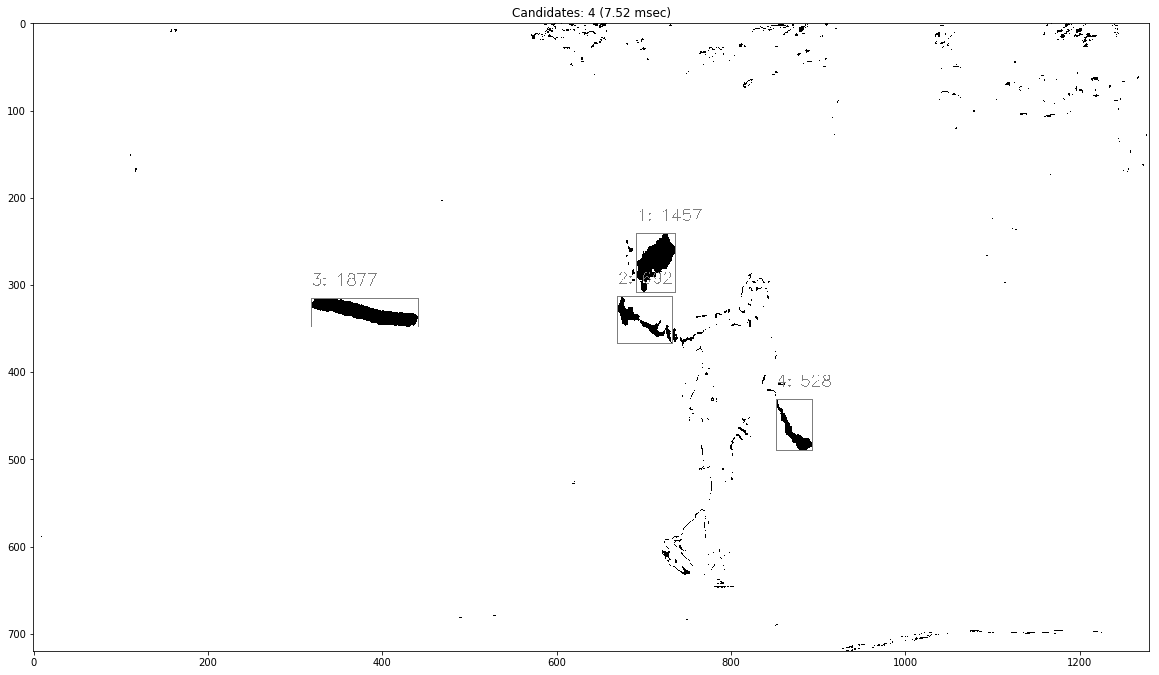

In [15]:
start = time.time()

# The original `detect` image was suitable for display, but it is "inverted" and not suitable
# for component detection; we need to invert it first.
nd = cv2.bitwise_not(detect)
num, labels, stats, centroids = cv2.connectedComponentsWithStats(nd, ltype=cv2.CV_16U)

plt.figure(figsize=(20, 30))

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.6
fontColor = 127
lineType = 1

# We set an arbitrary threshold to screen out smaller "components"
# which may result simply from noise, or moving leaves, and other
# elements not of interest.
min_area = 500


d = detect.copy()
candidates = list()
for stat in stats[1:]:
    area = stat[cv2.CC_STAT_AREA]
    if area < min_area:
        continue # Skip small objects (noise)
        
    lt = (stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP])
    rb = (lt[0] + stat[cv2.CC_STAT_WIDTH], lt[1] + stat[cv2.CC_STAT_HEIGHT])                                                
    bottomLeftCornerOfText = (lt[0], lt[1] - 15)

    candidates.append((lt, rb, area))
    cv2.rectangle(d, lt, rb, fontColor, lineType)

    cv2.putText(d, "{}: {:.0f}".format(len(candidates), stat[cv2.CC_STAT_AREA]),
                bottomLeftCornerOfText, 
                font, fontScale, fontColor, lineType)

plt.title("Candidates: {} ({:.2f} msec)".format(len(candidates),
                                            (time.time() - start) * 1000))
plt.imshow(d, 'gray')
print("Found {} components".format(num - 1))

## Motion model

For each of the candidates we must estimate the radius `r` and and trajectory P(t) (path at time `t`).

First we compute the [distance transform](https://docs.opencv.org/3.0-last-rst/modules/imgproc/doc/miscellaneous_transformations.html#distancetransform) `d(x)` for each inner pixel to the edge of the component and estimate the radius as:

    radius = max d(x)  for x in C
    
then we "thin" the pixels that satisfy

    d(x) > psi r

where `psi` is a threshold set at 0.7.

Once each candidate path is "thinned out" to only the pixels that could represent the FOM's motion, we compute the actual area and compare to the `expected_area` based on the estimated `radius`:

    expected_area = 2 radius |Pt| + pi radius^2

Ideally, we should only have **one** FOM emerging from the `candidates`.

0: radius: 14.76, len: 80.16, (A / A^ -1): 0.52
1: radius: 6.71, len: 82.98, (A / A^ -1): 0.45
2: radius: 9.22, len: 127.35, (A / A^ -1): 0.28
3: radius: 7.07, len: 72.42, (A / A^ -1): 0.55
Took 116.27793312072754 msec


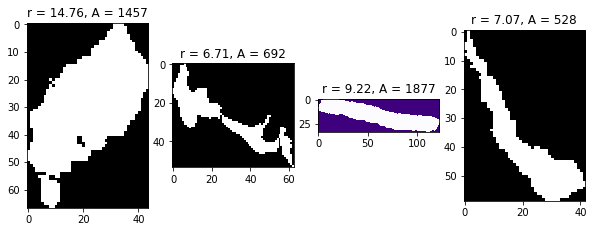

In [24]:
plt.figure(figsize=(10, 10), edgecolor='k')

# Thinning threshold.
psi = 0.7

# Area matching threshold.
gamma = 0.3

fom_detected = False
start = time.time()

sub_regions = list()
for i, candidate in enumerate(candidates):
    # The first two elements of each `candidate` tuple are
    # the opposing corners of the bounding box.
    x1, y1 = candidate[0]
    x2, y2 = candidate[1]
    
    # We had placed the candidate's area in the third element of the tuple.
    actual_area = candidate[2]
    
    # For each candidate, estimate the "radius" using a distance transform.
    # The transform is computed on the (small) bounding rectangle.
    cand = nd[y1:y2, x1:x2]
    dt = cv2.distanceTransform(cand, distanceType=cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)
    radius = np.amax(dt)

    # "Thinning" of pixels "close to the center" to estimate a
    # potential FOM path.
    ret, Pt = cv2.threshold(dt, psi * radius, 255, cv2.THRESH_BINARY)
    
    # TODO: compute actual path lenght, using best-fit straight line
    #   along the "thinned" path.
    # For now, we estimate it as the max possible lenght in the bounding box, its diagonal.
    w = x2 - x1
    h = y2 - y1
    path_len = math.sqrt(w * w + h * h)
    expected_area = radius * (2 * path_len + math.pi * radius)
    
    area_ratio = abs(actual_area / expected_area - 1)
    is_fom = area_ratio < gamma
    if is_fom and fom_detected:
        print("[WARN] More than one FOM detected")
    elif is_fom:
        fom_detected = True
        fom = i
    
    print("{}: radius: {:.2f}, len: {:.2f}, (A / A^ -1): {:.2f}".format(
        i, radius, path_len, area_ratio))
    
    plt.subplot(2, cols, i + 1)
    plt.imshow(cand, 'Purples_r' if is_fom else 'gray')
    plt.title("r = {:.2f}, A = {:.0f}".format(radius, actual_area))
    
print("Took {} msec".format((time.time() - start) * 1000))


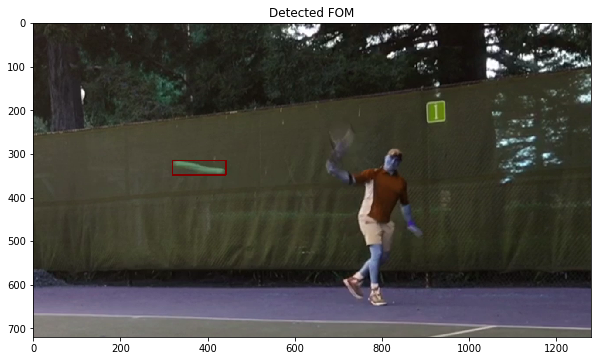

In [31]:
# The last-but-one was the original image processed, we can fetch it again.
img = cv2.imread(IMG_TEMPLATE.format(4))
plt.figure(figsize=(10, 10), edgecolor='r')
if fom_detected:
    cv2.rectangle(img, candidates[fom][0], candidates[fom][1], fontColor, 2)
    plt.imshow(img, 'gray')
    plt.title("Detected FOM".format(t))
